# 1. Import and Install Dependencies

In [ ]:
!pip install mediapipe

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time , random
import mediapipe as mp
import copy
import glob
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout,BatchNormalization,Input,Conv1D,MaxPooling1D,\
                                    TimeDistributed,Activation,Lambda,ReLU,Conv1D,ConvLSTM1D,Flatten
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint,EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,confusion_matrix
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import plot_model
import seaborn as sns

In [ ]:
# Check GPU Existing
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10402847423536942736
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17542723210118968189
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# 2. Keypoints using MP Holistic

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [ ]:
def mediapipe_detection(image, model):
    """
    inputs: CV2 Image
    output: Image, detected Landmarks
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable to Improve Perf.
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
# Draw Landmarks on Image
def draw_landmarks(image, results):
    """
    inputs: CV2 Image , Landmarks[Model Results]
    """
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [ ]:
# Draw Styled Landmarks on Image
def draw_styled_landmarks(image, results):
    """
    inputs: CV2 Image , Landmarks[Model Results]
    """
    # Draw face connections

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

# 3. Extract Keypoint Values

In [ ]:
# Extract Keypoints from Landmarks And Concatenate it in One Array
def extract_keypoints(results):
    """
    inputs: Resutls from MediaPipe Model
    output: Concatenated Landmarks
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Actions collected

In [ ]:
# Define our Actions
actions = np.array(['drink','eat','friend','goodbye','hello','help','how are you','no','yes','please','sorry','thanks','cry','i','they','you','what','name','teacher','family','happy','love','sad','laugh','neighbor','ok','read','write','school'])


# 5. Preprocess Data and Create Labels and Features

In [ ]:
# Labeling Actions to Numbers
label_map = {label:num for num, label in enumerate(actions)}

In [ ]:
label_map

# Load All Data




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT = '/content/drive/MyDrive/Graduation_Project/lstm_word_repo_grad'
DATA_PATH_KEYPOINTS = os.path.join(ROOT, 'FINAL_DATA')

In [ ]:
!unzip /content/drive/MyDrive/Graduation_Project/lstm_word_repo_grad/final_data.zip -d FINAL_DATA_PATH

In [ ]:
# Load Data 60 fps then Transform it to 30fps
sequences1, labels1 = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'60FPS',action,'*']))
    for sequence in list_seq:
        window = []
        # Take two Steps to Convert it To 30FPS
        for frame_num in range(0,60,2):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(sequence, "{}.npy".format(frame_num)))
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences1.append(window)
        labels1.append(label_map[action])
    print(f'action: {action} done.')

In [ ]:
#Convert Lists To Array
X2 = np.array(sequences1)
#Convert Labels to OHE
y2 = to_categorical(labels1).astype(int)
X2.shape, y2.shape

In [ ]:
# Load 30 Fps Data Folder
sequences, labels = [], []
for action in actions:
    list_seq = glob.glob('/'.join([DATA_PATH_KEYPOINTS,'30FPS',action,'*']))
    for sequence in list_seq:
        window = []
        for frame_num in range(0,30):
            #Load Frame Keypoints
            res1 = np.load(os.path.join(str(sequence), "{}.npy".format(frame_num)))
            #Take Hands Landmarks
            lh_rh = res1[1536:]
            #Remove z Axis From Landmarks
            for z in range(2,lh_rh.shape[0],3):
                    lh_rh[z] = None
            #Remove NaN Data
            lh_rh = lh_rh[np.logical_not(np.isnan(lh_rh))]
            window.append(lh_rh)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
#Convert Lists To Array
X1 = np.array(sequences)
#Convert Labels to OHE
y1 = to_categorical(labels).astype(int)
X1.shape, y1.shape

In [ ]:
# concatenate all data
X = np.concatenate([X1,X2])
y = np.concatenate([y1,y2])
X.shape,y.shape

## Data Augmentation

In [ ]:
# Rotation Augmentation
def augment_data_rotataion(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape:[Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)

    #Looping in all Examples
    for ex in range(X.shape[0]):
        # Get Random Angle Betwwen -5,5
        rotation_angle = random.randint(-5,5)
        # Convert it to Radians
        theta = np.radians(rotation_angle)
        c, s = np.cos(theta), np.sin(theta)
        # Build a Rotation Matrix
        rotation_matrix = np.array(((c, -s), (s, c)))
        # Looping Each Frame
        for frame in range(X.shape[1]):
            window = []
            # looping each Point within Frame
            for i in range(0,X.shape[2]-1,2):
                # Get Keypoint
                keypoint = np.array([X[ex][frame][i],X[ex][frame][i+1]])
                # Calculate Rotated Keypoint
                rotated_keypoint = np.dot(rotation_matrix, keypoint)
                keypoint_x = rotated_keypoint[0]
                keypoint_y = rotated_keypoint[1]
                # Append New Keypoint To our Data
                window.extend([keypoint_x,keypoint_y])
            augmented_X[ex][frame] = np.array(window)
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [ ]:
# Scale Augmentation
def augment_data_scale(X,y):
    '''
    input: X,y  as numpy array Shape: [Samples,Timesteps,Features]
    output: Augmented X,y as numpy array Shape: [Samples,Timesteps,Features]
    '''
    # Make an Array with Shape Like Original One
    augmented_X = np.zeros_like(X)
    augmented_y = np.zeros_like(y)
    # Looping in Each Sample
    for ex in range(X.shape[0]):
        # Get Random Scale Factor
        SCALE = round(random.random(),2)
        for frame in range(X.shape[1]):
            # Calculate New Point
            augmented_X[ex][frame] = X[ex][frame]*SCALE
        augmented_y[ex] = y[ex]
    return augmented_X,augmented_y

In [ ]:
# Augmented Rotated Data
rot_x,rot_y = augment_data_rotataion(X,y)
# Augmented Scaled Data
scaled_x,scaled_y = augment_data_scale(X,y)

In [ ]:
# concatenate all data [Original and Augmented]
X_ = np.concatenate([X,rot_x,scaled_x])
y_ = np.concatenate([y,rot_y,scaled_y])
X_.shape,y_.shape

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.20,shuffle=True,stratify=y_,random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 6. Build and Train Neural Network Models

In [ ]:
# Define The Time Steps
timesteps = X.shape[1]
# Define The Features No.
features = X.shape[2]

In [ ]:
MODELS_PATH = os.path.join(ROOT, 'Models')
LOGS_PATH = os.path.join(ROOT, 'Logs')

## 6.1 LSTM

In [ ]:
# Build a LSTM Model Arch
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(timesteps,features))) # frames * Features
model_lstm.add(LSTM(128, return_sequences=True, activation='relu'))
model_lstm.add(LSTM(64, return_sequences=False, activation='relu'))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(actions.shape[0], activation='softmax'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            38144     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 193004 (753.92 KB)
Trainable params: 19300

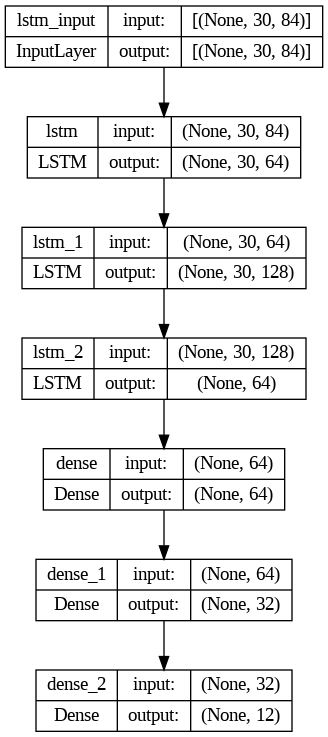

In [ ]:
# Assuming your model is called model_conv1d
plot_model(model_lstm, to_file=os.path.join(ROOT, 'model_lstm.png'), show_shapes=True)


In [ ]:
# Compilation Configuration
model_lstm.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
# Define Callbacks
log_dir = os.path.join(LOGS_PATH, 'LSTM3')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
mc = ModelCheckpoint(os.path.join(MODELS_PATH, 'LSTM3.h5'), monitor='val_categorical_accuracy', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,patience=100)
callbacks = [tb_callback,mc,es]

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train, epochs = 150, callbacks=[callbacks],batch_size=32,validation_data=(X_test,y_test),initial_epoch = 13)

Epoch 14/150
143/143 [==============================] - ETA: 0s - loss: 2.3794 - categorical_accuracy: 0.1782
Epoch 14: val_categorical_accuracy improved from -inf to 0.23726, saving model to Models/LSTM3.h5
143/143 [==============================] - 26s 146ms/step - loss: 2.3794 - categorical_accuracy: 0.1782 - val_loss: 2.2597 - val_categorical_accuracy: 0.2373
Epoch 15/150


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - ETA: 0s - loss: 1.9695 - categorical_accuracy: 0.3149
Epoch 15: val_categorical_accuracy improved from 0.23726 to 0.32689, saving model to Models/LSTM3.h5
143/143 [==============================] - 22s 153ms/step - loss: 1.9695 - categorical_accuracy: 0.3149 - val_loss: 1.8141 - val_categorical_accuracy: 0.3269
Epoch 16/150
143/143 [==============================] - ETA: 0s - loss: 1.8090 - categorical_accuracy: 0.3745
Epoch 16: val_categorical_accuracy improved from 0.32689 to 0.39367, saving model to Models/LSTM3.h5
143/143 [==============================] - 19s 134ms/step - loss: 1.8090 - categorical_accuracy: 0.3745 - val_loss: 1.6618 - val_categorical_accuracy: 0.3937
Epoch 17/150
143/143 [==============================] - ETA: 0s - loss: 1.5446 - categorical_accuracy: 0.4523
Epoch 17: val_categorical_accuracy improved from 0.39367 to 0.46221, saving model to Models/LSTM3.h5
143/143 [==============================] - 22s 152ms/step - loss

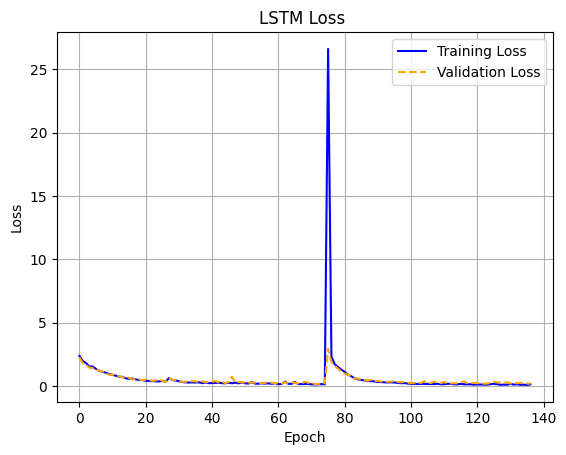

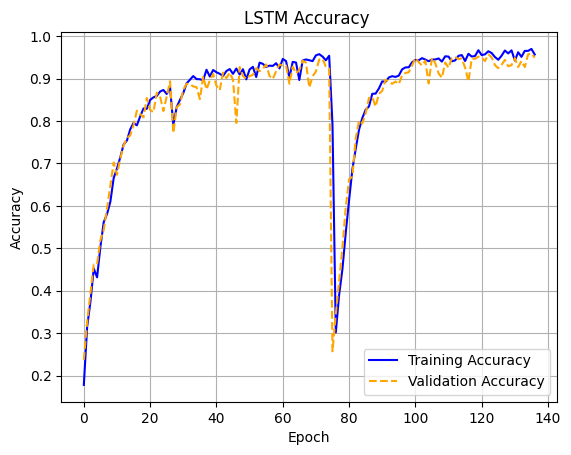

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history_lstm.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('LSTM Loss ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

print('')
# Plot training & validation accuracy values
plt.plot(history_lstm.history['categorical_accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('LSTM Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


## 6.4 Conv1d

In [ ]:
model_conv1d = Sequential()
model_conv1d.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model_conv1d.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_conv1d.add(Dropout(0.5))
model_conv1d.add(MaxPooling1D(pool_size=2))
model_conv1d.add(Flatten())
model_conv1d.add(Dense(100, activation='relu'))
model_conv1d.add(Dense(actions.shape[0], activation='softmax'))
model_conv1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_conv1d.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 28, 64)            16192     
                                                                 
 conv1d_2 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 dropout (Dropout)           (None, 26, 64)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 13, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 832)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               83300     
                                                      

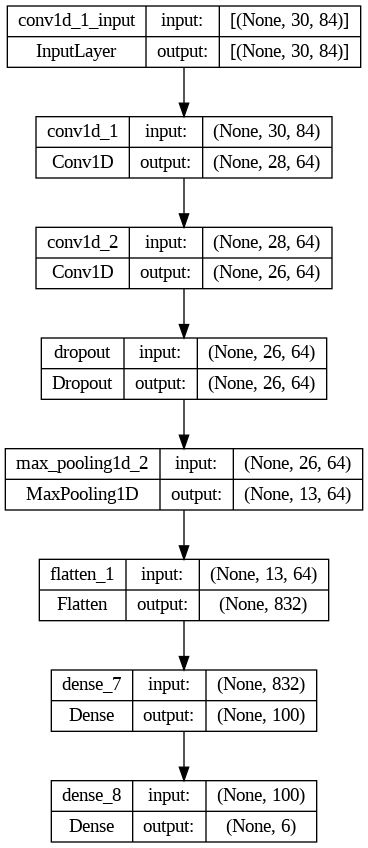

In [ ]:
plot_model(model_conv1d, to_file=os.path.join(ROOT, 'model_conv1d.png'), show_shapes=True)

In [ ]:
log_dir = os.path.join(LOGS_PATH, 'Conv1d')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
mc = ModelCheckpoint(os.path.join(MODELS_PATH, 'model_conv1d.h5'), monitor='val_categorical_accuracy', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,patience=50)
callbacks = [tb_callback,mc,es]

In [ ]:
model_conv1d.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
history_model_conv1d=model_conv1d.fit(X_train, y_train, epochs=150, callbacks=[callbacks],batch_size=1,validation_data=(X_test,y_test))

Epoch 1/150
2265/2275 [============================>.] - ETA: 0s - loss: 0.8835 - categorical_accuracy: 0.6746
Epoch 1: val_categorical_accuracy improved from -inf to 0.75923, saving model to Models/model_conv1d.h5
2275/2275 [==============================] - 20s 8ms/step - loss: 0.8819 - categorical_accuracy: 0.6747 - val_loss: 0.6001 - val_categorical_accuracy: 0.7592
Epoch 2/150
  36/2275 [..............................] - ETA: 10s - loss: 0.4775 - categorical_accuracy: 0.8333

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2270/2275 [============================>.] - ETA: 0s - loss: 0.4390 - categorical_accuracy: 0.8542
Epoch 2: val_categorical_accuracy improved from 0.75923 to 0.93146, saving model to Models/model_conv1d.h5
2275/2275 [==============================] - 13s 6ms/step - loss: 0.4381 - categorical_accuracy: 0.8545 - val_loss: 0.3363 - val_categorical_accuracy: 0.9315
Epoch 3/150
2272/2275 [============================>.] - ETA: 0s - loss: 0.2747 - categorical_accuracy: 0.9093
Epoch 3: val_categorical_accuracy improved from 0.93146 to 0.94200, saving model to Models/model_conv1d.h5
2275/2275 [==============================] - 19s 8ms/step - loss: 0.2744 - categorical_accuracy: 0.9095 - val_loss: 0.2367 - val_categorical_accuracy: 0.9420
Epoch 4/150
2269/2275 [============================>.] - ETA: 0s - loss: 0.2313 - categorical_accuracy: 0.9357
Epoch 4: val_categorical_accuracy improved from 0.94200 to 0.94728, saving model to Models/model_conv1d.h5
2275/2275 [==============================]

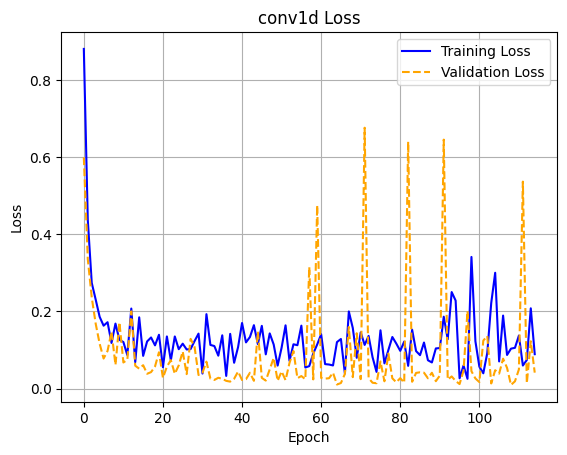

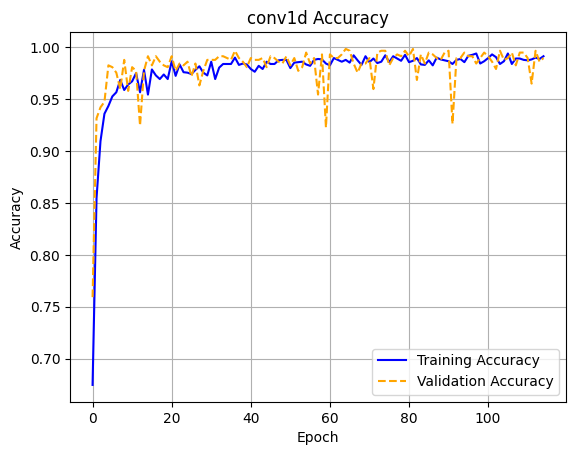

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_conv1d.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history_model_conv1d.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('conv1d Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
print("")
# Plot training & validation accuracy values
plt.plot(history_model_conv1d.history['categorical_accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history_model_conv1d.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('conv1d Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


## 6.6 Transformer

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(actions.shape[0], activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [ ]:
input_shape = X_train.shape[1:]

In [ ]:
model_transformer = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
model_transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 84)]             0         []                            
                                                                                                  
 layer_normalization (Layer  (None, 30, 84)               168       ['input_2[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 30, 84)               347220    ['layer_normalization[0][0]', 
 iHeadAttention)                                                     'layer_normalization[0][0]'] 
                                                                                              

In [ ]:
model_transformer.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-5),
    metrics=["categorical_accuracy"],
)

In [ ]:
log_dir = os.path.join(LOGS, 'transformer_encoder')
tb_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,
                          update_freq='epoch',
                          profile_batch=0) ## !tensorboard --logdir=.
# mc = ModelCheckpoint(os.path.join(MODELS_PATH, 'model_transformer_encoder.h5'), monitor='val_categorical_accuracy', mode='max', verbose=1,save_best_only=True)
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1,patience=100)
callbacks = [tb_callback,es]

In [ ]:
history_model_transformer=model_transformer.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=8,
    callbacks=callbacks,
)

In [ ]:
model_transformer.save(os.path.join(MODELS_PATH, 'model_transformer_encoder.h5'))

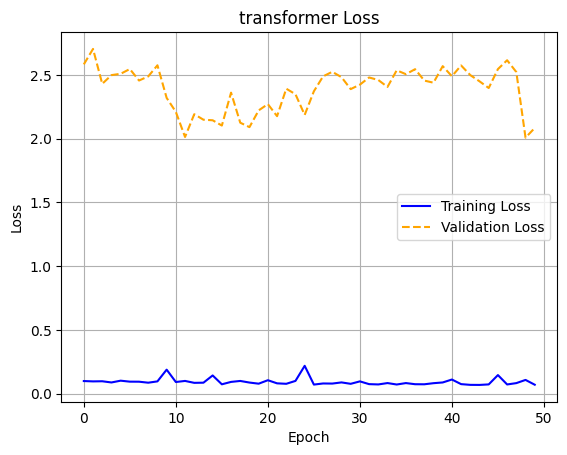

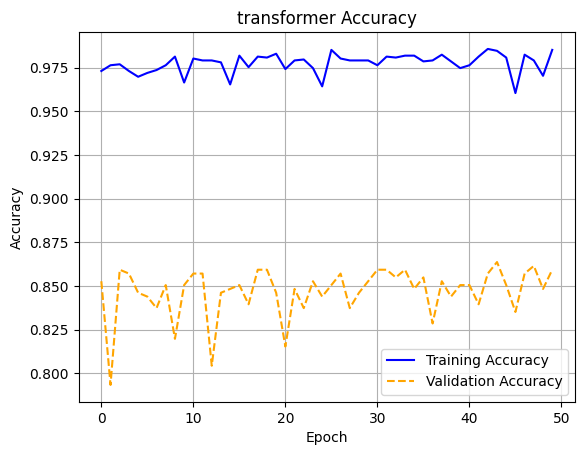

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_transformer.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history_model_transformer.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('transformer Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()
print("")
# Plot training & validation accuracy values
plt.plot(history_model_transformer.history['categorical_accuracy'], label='Training Accuracy', color='blue', linestyle='-')
plt.plot(history_model_transformer.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
plt.title('transformer Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
